In [1]:
import sympy as sp
import jax.numpy as np
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

Euler–Tricomi equation

$ \displaystyle
x^2 \frac{d^2u}{dx^2} + y^2 \frac{d^2u}{dy^2} = 0
$

$ \displaystyle
u(x, y) = \sin(x)\text{, where }y = x^2
\\ \displaystyle
u(0, y) = y^2
$

In [2]:
config = Config(
  eq = EqInfo(
    name = 'u',
    function = lambda s: s.x**2 * s.d2udx2 + s.y**2 * s.d2udy2,
  ),
  vars = {
    'x': VarInfo(bounds=(0, 2)),
    'y': VarInfo(bounds=(0, 2)),
  },
  conditions = [
    (1., lambda s: s.u.subs(s.y, s.x**2) - sp.sin(s.x)),
    (1., lambda s: s.u.subs(s.x, 0) - s.y**2),
  ],
  preoperations = [
    lambda x, y: 0,
    lambda x, y: 1,
    lambda x, y: x,
    lambda x, y: y,
    lambda x, y: x + y,
    lambda x, y: x * y,
  ],
  operations = [
    lambda z, _: 0,
    lambda z, _: 1,
    lambda z, _: z,
    lambda z, _: -z,
    lambda z, s: z * s.x,
    lambda z, s: z * s.y,
    lambda z, _: sp.exp(z),
    lambda z, _: sp.sin(z),
  ],
  hyperparameters = Hyperparameters(
    lr = 0.002,
    penalty = 1,
    nodecount = 5,
  ),
  epochs = 256,
  samples = 512,
  batchsize = 128,
  verbosity = 1,
)

In [3]:
network, best, loss_histories = run(config)

20:02:14.604 [INFO] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
20:02:14.605 [INFO] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
20:02:14.608 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
20:02:14.609 [INFO] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
20:02:15.101 [INFO] Constructed symbolic model
20:02:22.857 [INFO] Constructed loss equation
20:02:32.993 [INFO] Constructed JAXified model
20:02:41.705 [INFO] Epoch: 1, Loss: 13.2080097198
20:02:41.941 [INFO] Epoch: 10, Loss: 5.1319899559
20:02:42.223 [INFO] Epoch: 20, Loss: 2.3169460297
20:02:42.480 [INFO] Epoch: 30, Loss: 1.6759221554
20:02:42.749 [INFO] Epoch: 40, Loss: 1.6335860491
20:02:4

Nothing more to prune!


$\displaystyle - 1.053338832861 x y + 0.495143982030023 x + 0.557947342762368 y^{2} + 0.0786390291381303 y + 0.922053234446157 \sin{\left(0.976893961429596 y \right)} + 0.652301847934723 \sin{\left(0.26658496260643 x + 0.496432423591614 \sin{\left(0.976893961429596 y \right)} \right)} - 0.294711053371429$

Best loss: 0.10437565296888351


In [4]:
prediction_best = best.model.subs(zip(best.alphas, best.W))
print(sp.latex(prediction_best))

- 1.053338832861 x y + 0.495143982030023 x + 0.557947342762368 y^{2} + 0.0786390291381303 y + 0.922053234446157 \sin{\left(0.976893961429596 y \right)} + 0.652301847934723 \sin{\left(0.26658496260643 x + 0.496432423591614 \sin{\left(0.976893961429596 y \right)} \right)} - 0.294711053371429


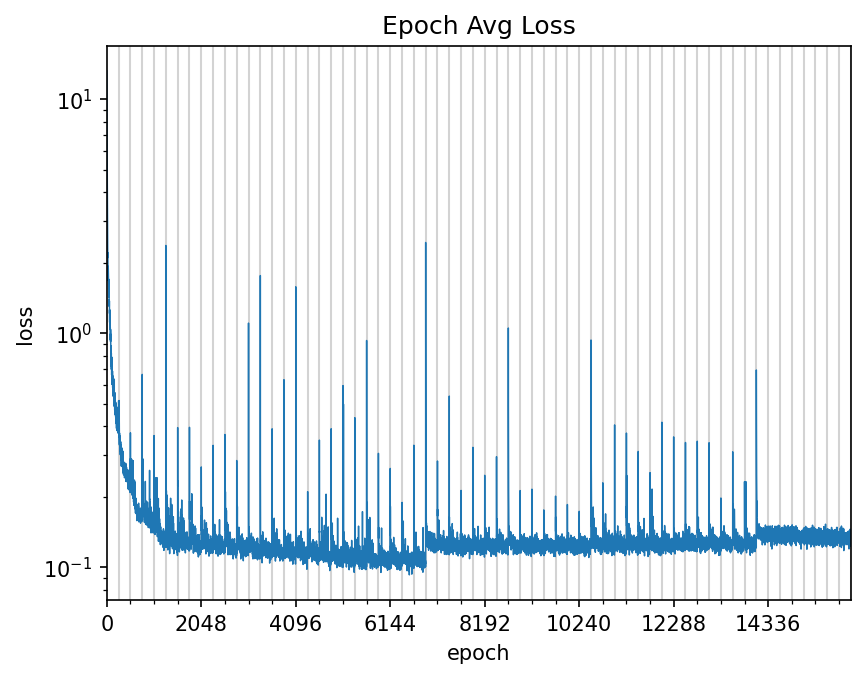

In [5]:
loss_history = []
prunepoints = []

for pruneepoch in loss_histories:
  count = 0 if len(prunepoints) == 0 else prunepoints[len(prunepoints)-1]
  for epoch in pruneepoch:
    loss_history += [np.average(np.array(epoch))]
    count += 1
  prunepoints += [count]

plt.title('Epoch Avg Loss')
plt.xlabel('epoch')
plt.xlim((0, prunepoints[len(prunepoints) - 1]))
# plt.ylim((min(loss_history)*0.5, 2))
plt.gcf().gca().xaxis.set_major_locator(plt.MultipleLocator(2048))
plt.gcf().gca().xaxis.set_minor_locator(plt.MultipleLocator(512))
plt.yscale('log')
plt.ylabel('loss')
for prunepoint in prunepoints:
  plt.axvline(prunepoint, color='lightgrey', linewidth=1)
plt.plot(loss_history, linewidth=0.7)
plt.gcf().set_dpi(150)
plt.show()

In [6]:
u = prediction_best
x = network.symbols.x
y = network.symbols.y
d2udx2 = sp.diff(u, x, 2)
d2udy2 = sp.diff(u, y, 2)

error = x**2 * d2udx2 - y**2 * d2udy2
error_c1 = prediction_best.subs(y, x**2) - sp.sin(x)
error_c2 = prediction_best.subs(x, 0) - y**2
errorlambdified = sp.lambdify([x, y], error**2 + error_c1**2 + error_c2**2, modules='jax')
tt, xx = np.meshgrid(np.arange(*config.vars['x'].bounds, 0.01), np.arange(*config.vars['y'].bounds, 0.01))
np.mean(errorlambdified(tt, xx)).item()

0.15527494251728058

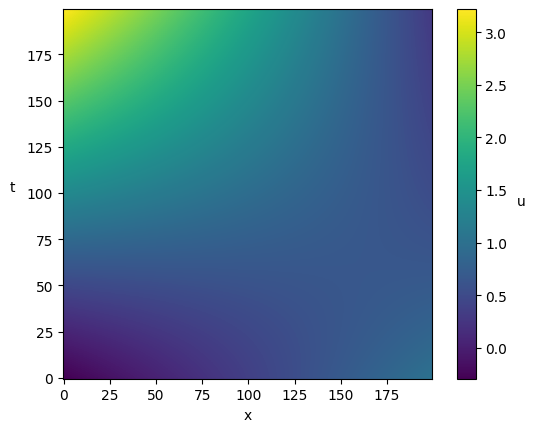

In [7]:
u_lambd = sp.lambdify([x, y], prediction_best, modules='jax')
plt.imshow(u_lambd(tt, xx), origin="lower")
plt.colorbar().set_label('u', rotation=0, labelpad=10)
plt.xlabel('x')
plt.ylabel('t', rotation=0, labelpad=10)
plt.show()